In [1]:
# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model

import keras

from sklearn.utils import class_weight

# others
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import rankdata

# for confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# filter warning

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
plt.style.use('ggplot')

# Stations:

In [3]:
# load GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)  # access from Google Drive

folder = './gdrive/My Drive/Deep-Learning/'

# locations

locations = pd.read_csv(folder+'stations.txt', sep=' ', index_col=0)

locations.head(20)

Mounted at /content/gdrive


,database,station_latitude(dec.degree),station_longitude(dec.degree),station_altitude(m)
station_name,,,,
TILLABERI,AMMA-CATCH,14.204300,1.454500,212.0
TOBRE,AMMA-CATCH,10.199100,2.133500,371.0
TARA,AMMA-CATCH,15.251400,-1.585500,335.0
AGOUFOU,AMMA-CATCH,15.360000,-1.470000,340.0
LAWRA,MARLOES,10.866670,-1.483330,305.0
NAVRONGO,MARLOES,10.530000,-1.050000,201.3
OUAHIGOUYA,MARLOES,13.520000,-2.390000,365.0
TAMALE,MARLOES,9.330000,-0.510000,183.3
WA,MARLOES,10.030000,-2.090000,322.7


# Load 3 satellite DataFrames

In [4]:
# import the CMORPH data

df_cmorph = pd.read_csv(folder+'UpdatedResolutions_CMORPH_overlapping.csv', index_col=0)
df_cmorph.index = pd.to_datetime(df_cmorph.index, errors='coerce')

# import the TAMSAT data

df_tamsat = pd.read_csv(folder+'UpdatedResolutions_TAMSAT_overlapping.csv', index_col=0)
df_tamsat.index = pd.to_datetime(df_tamsat.index, errors='coerce')

# import the IMERG data

df_imerg = pd.read_csv(folder+'UpdatedResolutions_IMERG_overlapping.csv', index_col=0)
df_imerg.index = pd.to_datetime(df_imerg.index, errors='coerce')




# check the dataset shapes

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)

 
Dataset shapes
------------------------------
(16026, 1027) (16026, 1027) (16026, 1027)


# Split datasets

### Wet season

In [ ]:
# keep the wet season months:

df_cmorph = df_cmorph[ df_cmorph.index.month.isin([5, 6, 7, 8, 9]) ]
df_tamsat = df_tamsat[ df_tamsat.index.month.isin([5, 6, 7, 8, 9]) ]
df_imerg  = df_imerg[  df_imerg.index.month.isin([5, 6, 7, 8, 9])  ]


# check the dataset

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)

 
Dataset shapes
------------------------------
(16026, 1027) (16026, 1027) (16026, 1027)


### Classify between wet and dry days

In [5]:
# classify

thr = 1.0  # mm/day, threshold between rainy and wet days

# binary values

df_cmorph['Rain'] = df_cmorph['R[mm]']
df_cmorph['Rain'][df_cmorph['R[mm]'] < thr] = 0.0
df_cmorph['Rain'][df_cmorph['R[mm]'] >= thr] = 1.0

# we will not need the 'R[mm]' column any more

prec = df_cmorph['R[mm]']
df_cmorph.drop(['R[mm]'], axis=1, inplace=True)

df_cmorph

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,latitude,dataset,Rain
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-08,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.169223,0.075751,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.298822,1.185205,2.321692,3.045660,3.254830,2.943529,1.136461,0.476312,0.176544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187106,0.262240,0.221734,14.204300,CMORPH,0.0
2000-06-09,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,1.488693,1.740370,1.085444,0.192998,0.000000,6.483722,19.811516,23.006424,18.560978,11.936769,11.024746,10.506308,11.183578,12.820748,15.571081,8.413095,4.135703,5.314629,6.725379,10.718180,16.291904,20.385557,21.129496,18.566637,8.982130,7.301218,6.607963,6.231372,4.383336,4.409812,3.324329,0.642646,0.355685,0.215835,0.074550,0.000000,0.000000,14.204300,CMORPH,0.0
2000-06-10,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,16.517967,15.735293,16.264442,14.935356,13.077184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125696,0.000000,0.000000,0.140034,0.116601,0.528398,1.402359,1.180172,0.942927,1.883932,4.107148,6.503812,13.792906,15.689438,16.826096,17.656454,19.203127,16.236609,16.075899,14.863060,13.357284,12.070374,11.942576,10.774127,14.204300,CMORPH,0.0
2000-06-11,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,0.285462,0.175417,0.466907,1.377465,0.650208,14.934494,10.356865,8.188148,8.380214,6.295541,5.732327,5.205595,5.487986,5.166414,3.449150,2.022675,2.205905,2.067136,1.933892,1.227386,0.520791,0.000000,0.000000,0.000000,0.000000,0.000000,0.088741,0.117984,0.122882,0.109459,0.124830,0.090816,0.084605,0.200180,0.392871,0.256930,0.000000,14.204300,CMORPH,0.0
2000-06-12,0.00,0.00,0.00,0.00,0.217778,0.141667,0.00,0.00,0.00,0.00,0.00,0.00,0.245,0.231111,0.131667,0.268741,0.128191,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,0.000000,0.000000,0.114463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100878,1.468175,0.932161,5.676294,2.758598,1.274993,0.653104,0.365603,0.000000,0.082567,0.258888,0.147319,1.292727,2.103040,2.557600,2.628348,2.530024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.204300,CMORPH,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-26,0.00,0.00,3.38,0.00,0.000000,2.520000,1.09,1.44,2.39,1.29,2.17,2.06,6.760,8.809999,23.469999,26.930000,29.920000,19.639999,26.449999,22.769999,

In [6]:
# labels are the rainfall intermittency sequence

y = df_cmorph['Rain']
print(y.shape, prec.shape)

df = df_cmorph['latitude']
x_cmorph = df_cmorph.drop(['Rain',  'dataset', 'latitude'], axis=1)
x_tamsat = df_tamsat.drop(['R[mm]', 'dataset', 'latitude'], axis=1)
x_imerg  = df_imerg.drop([ 'R[mm]', 'dataset', 'latitude'], axis=1)
print(x_cmorph.shape, x_tamsat.shape, x_imerg.shape)



# reshape to (x, 32, 32)

pixels = 32  # insert 32 for 32 * 32, 16 for 16 * 16 etc.


x_cmorph = x_cmorph.to_numpy()
x_cmorph = np.reshape(x_cmorph, (len(x_cmorph), pixels, pixels))  # is the reshape correct?

x_tamsat = x_tamsat.to_numpy()
x_tamsat = np.reshape(x_tamsat, (len(x_tamsat), pixels, pixels))

x_imerg = x_imerg.to_numpy()
x_imerg = np.reshape(x_imerg, (len(x_imerg), pixels, pixels))

print(x_cmorph.shape, x_tamsat.shape, x_imerg.shape)




# the input has to be (x, 32, 32, 3)

x = np.zeros((len(df_cmorph), pixels, pixels, 3))

x[:, :, :, 0] = x_cmorph
x[:, :, :, 1] = x_tamsat
x[:, :, :, 2] = x_imerg

print(' ')
print(f'Final shape')
print(f'---' * 10)

print(x.shape)

(16026,) (16026,)
(16026, 1024) (16026, 1024) (16026, 1024)
(16026, 32, 32) (16026, 32, 32) (16026, 32, 32)
 
Final shape
------------------------------
(16026, 32, 32, 3)


# Input 16x16

We will try to turn the 32x32 input to 16x16 and see the difference in results. The first and last 8x32 collumns will be dropped, also the left and right ones. The final number of collumns has to be 16x16 = 256 collumns. 



Drop the 8 northern collumns:

In [ ]:
up = np.arange(0, 8 * 32)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,Rain
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.14,0.52,0.94,1.26,1.04,1.34,1.34,4.45,10.30,10.47,8.65,6.59,7.530000,8.120000,6.42,6.86,7.34,7.57,7.74,14.40,11.17,10.85,6.61,7.46,11.11,7.94,6.75,4.42,5.04,3.77,0.69,0.65,0.39,0.41,0.93,1.17,1.09,1.81,1.46,0.0
1999-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.32,0.20,3.54,3.87,2.88,1.70,1.67,3.91,4.44,4.55,2.52,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1999-05-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,1.54,0.90,0.13,0.52,0.40,0.55,0.83,8.58,6.99,9.88,10.05,12.00,12.520000,6.250000,3.38,8.61,9.61,11.54,16.28,8.89,9.84,7.95,7.12,5.31,2.92,2.84,3.39,3.78,3.02,2.34,1.53,2.76,1.78,1.46,0.49,0.00,0.58,1.16,1.24,0.0
1999-05-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.03,0.16,0.02,0.14,0.15,0.20,0.21,0.12,0.12,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1999-05-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.07,6.45,12.94,14.56,15.78,16.790001,17.280001,11.87,9.31,8.41,9.43,8.12,4.44,0.00,0.05,0.03,0.01,0.00,0.00,0.06,0.07,0.07,0.05,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-16,62.0,53.0,52.0,55.0,53.0,58.0,62.0,62.0,58.00,56.00,55.0,53.0,54.0,50.0,48.0,52.0,52.0,51.0,48.0,38.0,48.0,51.0,36.0,37.0,40.0,52.0,47.0,32.0,35.0,30.0,30.0,28.0,60.0,58.0,53.0,51.0,56.0,64.0,60.00,57.0,...,18.00,21.00,21.00,22.00,25.00,24.00,24.00,30.00,25.00,29.00,32.00,25.00,24.000000,18.000000,30.00,26.00,28.00,26.00,24.00,31.00,30.00,27.00,27.00,31.00,32.00,30.00,27.00,27.00,22.00,22.00,25.00,25.00,27.00,24.00,19.00,21.00,24.00,21.00,20.00,1.0
2015-09-19,52.0,61.0,62.0,66.0,69.0,57.0,45.0,29.0,43.00,60.00,48.0,47.0,36.0,45.0,36.0,39.0,40.0,45.0,52.0,53.0,42.0,43.0,52.0,51.0,43.0,46.0,48.0,53.0,50.0,54.0,56.0,47.0,48.0,54.0,63.0,60.0,64.0,60.0,38.00,40.0,...,27.00,25.00,21.00,16.00,19.00,20.00,23.00,49.00,53.00,54.00,51.00,57.00,56.000000,55.000000,53.00,57.00,57.00,51.00,49.00,44.00,47.00,45.00,44.00,38.00,26.00,32.00,26.00,23.00,24.00,23.00,15.00,15.00,18.00,23.00,22.00,19.00,20.00,23.00,22.00,1.0
2015-09-22,37.0,37.0,30.0,32.0,18.0,8.0,24.0,28.0,30.00,26.00,30.0,32.0,38.0,30.0,34.0,28.0,36.0,30.0,26.0,30.0,28.0,33.0,32.0,28.0,26.0,30.0,26.0,19.0,14.0,12.0,12.0,12.0,36.0,40.0,40.0,30.0,18.0,10.0,27.00,27.0,...,13.00,10.00,10.00,9.00,10.00,12.00,10.00,22.00,24.00,29.00,36.00,32.00,32.000000,36.000000,34.00,36.00,33.00,37.00,37.00,37.00,30.00,18.00,17.00,15.0

Drop the 8 southern collumns:

In [ ]:
up = np.arange(1024 - 8 * 32, 1024)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Rain
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,5.24,3.820000,7.470000,5.01,7.54,9.66,15.75,8.92,7.22,3.08,2.69,2.11,1.03,0.77,1.20,1.39,2.15,1.89,1.71,1.18,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910000,0.830000,0.44,0.080000,0.000000,0.00,0.16,0.52,1.11,0.51,0.92,1.17,1.17,1.25,1.18,1.22,0.94,0.63,0.29,0.25,0.14,0.14,0.24,0.18,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270000,0.190000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.269999,26.530001,21.35,22.139999,21.529999,22.94,19.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-16,62.0,53.0,52.0,55.0,53.0,58.0,62.0,62.0,58.00,56.00,55.0,53.0,54.0,50.0,48.0,52.0,52.0,51.0,48.0,38.0,48.0,51.0,36.0,37.0,40.0,52.0,47.0,32.0,35.0,30.0,30.0,28.0,60.0,58.0,53.0,51.0,56.0,64.0,60.00,57.0,...,34.0,42.0,40.0,40.0,36.0,25.0,21.0,43.000000,43.000000,45.00,36.000000,36.000000,30.00,33.00,37.00,40.00,40.00,50.00,45.00,45.00,45.00,32.00,32.00,32.00,25.00,30.00,27.00,31.00,24.00,30.00,22.00,29.00,33.0,36.0,40.0,36.0,32.0,22.0,22.0,1.0
2015-09-19,52.0,61.0,62.0,66.0,69.0,57.0,45.0,29.0,43.00,60.00,48.0,47.0,36.0,45.0,36.0,39.0,40.0,45.0,52.0,53.0,42.0,43.0,52.0,51.0,43.0,46.0,48.0,53.0,50.0,54.0,56.0,47.0,48.0,54.0,63.0,60.0,64.0,60.0,38.00,40.0,...,32.0,30.0,36.0,33.0,42.0,48.0,48.0,51.000000,45.000000,45.00,52.000000,53.000000,57.00,51.00,60.00,60.00,60.00,49.00,46.00,45.00,40.00,49.00,46.00,44.00,40.00,36.00,36.00,30.00,35.00,36.00,42.00,35.00,27.0,34.0,32.0,33.0,36.0,41.0,39.0,1.0
2015-09-22,37.0,37.0,30.0,32.0,18.0,8.0,24.0,28.0,30.00,26.00,30.0,32.0,38.0,30.0,34.0,28.0,36.0,30.0,26.0,30.0,28.0,33.0,32.0,28.0,26.0,30.0,26.0,19.0,14.0,12.0,12.0,12.0,36.0,40.0,40.0,30.0,18.0,10.0,27.00,27.0,...,10.0,8.0,10.0,8.0,10.0,8.0,8.0,17.000000,19.000000,18.00,24.000000,24.000000,25.00,25.00,20.00,20.00,20.00,19.00,18.00,18.00,17.00,15.00,10.00,10.00,7.00,6.00,7.00,10.00,10.00,12.00,12.00,12.00,10.0,10.0,10.0,10.0,8.0,6.0,8.

The next step is: drop 8, keep 16, drop 8.

In [ ]:
# drop the first 8

up = np.arange(256, 264)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# drop the last 8

up = np.arange(760, 768)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

for i in range(280, 759, 32):

  up = np.arange(i, i + 16)
  up = up.astype("str")

  print('The collumns to be dropped:', up)

  df.drop(up, axis=1, inplace=True)


# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

The collumns to be dropped: ['280' '281' '282' '283' '284' '285' '286' '287' '288' '289' '290' '291'
 '292' '293' '294' '295']
The collumns to be dropped: ['312' '313' '314' '315' '316' '317' '318' '319' '320' '321' '322' '323'
 '324' '325' '326' '327']
The collumns to be dropped: ['344' '345' '346' '347' '348' '349' '350' '351' '352' '353' '354' '355'
 '356' '357' '358' '359']
The collumns to be dropped: ['376' '377' '378' '379' '380' '381' '382' '383' '384' '385' '386' '387'
 '388' '389' '390' '391']
The collumns to be dropped: ['408' '409' '410' '411' '412' '413' '414' '415' '416' '417' '418' '419'
 '420' '421' '422' '423']
The collumns to be dropped: ['440' '441' '442' '443' '444' '445' '446' '447' '448' '449' '450' '451'
 '452' '453' '454' '455']
The collumns to be dropped: ['472' '473' '474' '475' '476' '477' '478' '479' '480' '481' '482' '483'
 '484' '485' '486' '487']
The collumns to be dropped: ['504' '505' '506' '507' '508' '509' '510' '511' '512' '513' '514' '515'
 '516' '51

,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,328,329,330,331,332,333,334,335,...,689,690,691,692,693,694,695,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,Rain
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-01,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.14,0.28,0.45,0.08,0.0,0.0,0.0,3.27,3.51,4.17,2.37,1.60,0.90,0.42,0.28,0.76,0.95,0.51,0.64,0.64,0.79,0.00,0.00,15.75,8.92,7.22,3.08,2.69,2.11,1.03,0.77,1.20,1.39,2.15,1.89,1.71,1.18,0.00,0.00,0.0
1999-05-04,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.07,0.1,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.10,0.00,0.41,6.78,0.71,0.57,0.46,0.35,0.00,0.00,0.00,0.02,0.02,0.02,0.03,0.03,1.11,0.51,0.92,1.17,1.17,1.25,1.18,1.22,0.94,0.63,0.29,0.25,0.14,0.14,0.24,0.18,0.0
1999-05-07,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1999-05-10,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1999-05-13,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-16,58.00,56.00,55.0,53.0,54.0,50.0,48.0,52.0,52.0,51.0,48.0,38.0,48.0,51.0,36.0,37.0,53.00,53.00,52.00,50.00,47.0,54.0,52.0,54.0,52.0,50.0,50.0,38.0,47.0,44.0,42.0,37.0,53.00,51.0,55.00,53.0,56.0,56.0,54.0,50.0,...,45.00,37.00,35.00,27.00,36.0,40.0,40.0,45.00,45.00,48.00,50.00,47.00,40.00,32.00,28.00,37.00,40.00,35.00,30.00,30.00,33.00,35.00,35.00,40.00,40.00,50.00,45.00,45.00,45.00,32.00,32.00,32.00,25.00,30.00,27.00,31.00,24.00,30.00,22.00,1.0
2015-09-19,43.00,60.00,48.0,47.0,36.0,45.0,36.0,39.0,40.0,45.0,52.0,53.0,42.0,43.0,52.0,51.0,53.00,57.00,58.00,53.00,36.0,43.0,33.0,42.0,46.0,45.0,50.0,51.0,41.0,46.0,44.0,52.0,54.00,53.0,63.00,57.0,38.0,36.0,35.0,45.0,...,33.00,32.00,33.00,32.00,24.0,23.0,33.0,69.00,64.00,53.00,51.00,53.00,50.00,57.00,56.00,39.00,35.00,34.00,31.00,24.00,26.00,29.00,36.00,60.00,60.00,49.00,46.00,45.00,40.00,49.00,46.00,44.00,40.00,36.00,36.00,30.00,35.00,36.00,42.00,1.0
2015-09-22,30.00,26.00,30.0,32.0,38.0,30.0,34.0,28.0,36.0,30.0,26.0,30.0,28.0,33.0,32.0,28.0,28.00,26.00,26.00,30.00,34.0,32.0,34.0,30.0,30.0,30.0,26.0,32.0,33.0,32.0,26.0,30.0,30.00,30.0,30.00,25.0,34.0,36.0,34.0,30.0,...,7.00,7.00,6.00,5.00,6.0,7.0,8.0,10.00,12.00,19.00,10.00,11.00,11.00,10.00,6.00,8.00,7.00,6.00,7.00,6.00,5.00,8.00,8.00,20.00,20.00,19.00,18.00,18.00,17.00,15.00,10.00,10.00,7.00,6.00,7.00,10.00,10.00,12.00,12.00,1.0


### We finally have 16x16 = 256 pixel collumns left!

# Input 8x8

We will try to turn the 32x32 input to 8x8 and see the difference in the results. The first and last 12x32 collumns will be dropped, also the left and right ones. The final number of collumns has to be 8x8 = 64 collumns.

Drop the 12 northern collumns:

In [ ]:
up = np.arange(0, 12 * 32)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,R[mm],384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,...,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.07,0.09,0.13,0.13,0.14,0.21,0.19,0.19,0.21,0.23,0.30,0.30,0.36,0.41,0.56,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,14.204300,MSWEP
1999-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,14.204300,MSWEP
1999-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,14.204300,MSWEP
1999-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.62,4.21,4.17,4.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.40,7.02,6.78,4.30,4.37,4.35,0.0,0.0,14.204300,MSWEP
1999-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.61,4.93,4.74,5.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.71,3.63,2.72,3.15,5.97,5.93,8.44,8.14,7.93,5.11,5.02,5.13,0.0,0.0,14.204300,MSWEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.261641,RFE
2015-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.261641,RFE
2015-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.261641,RFE


Drop the 12 southern collumns:

In [ ]:
up = np.arange(1024 - 12 * 32, 1024)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,R[mm],384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,...,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.61,0.58,0.64,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54,0.61,0.65,0.65,0.71,0.7,0.0,0.0,14.204300,MSWEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,11.261641,RFE
2015-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,11.261641,RFE
2015-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,11.261641,RFE


The next step is: drop 12, keep 8, drop 12

In [ ]:
# drop the first 12

up = np.arange(384, 396)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# drop the last 12

up = np.arange(628, 640)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

for i in range(404, 622, 32):

  up = np.arange(i, i + 24)
  up = up.astype("str")

  print('The collumns to be dropped:', up)

  df.drop(up, axis=1, inplace=True)


# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

The collumns to be dropped: ['404' '405' '406' '407' '408' '409' '410' '411' '412' '413' '414' '415'
 '416' '417' '418' '419' '420' '421' '422' '423' '424' '425' '426' '427']
The collumns to be dropped: ['436' '437' '438' '439' '440' '441' '442' '443' '444' '445' '446' '447'
 '448' '449' '450' '451' '452' '453' '454' '455' '456' '457' '458' '459']
The collumns to be dropped: ['468' '469' '470' '471' '472' '473' '474' '475' '476' '477' '478' '479'
 '480' '481' '482' '483' '484' '485' '486' '487' '488' '489' '490' '491']
The collumns to be dropped: ['500' '501' '502' '503' '504' '505' '506' '507' '508' '509' '510' '511'
 '512' '513' '514' '515' '516' '517' '518' '519' '520' '521' '522' '523']
The collumns to be dropped: ['532' '533' '534' '535' '536' '537' '538' '539' '540' '541' '542' '543'
 '544' '545' '546' '547' '548' '549' '550' '551' '552' '553' '554' '555']
The collumns to be dropped: ['564' '565' '566' '567' '568' '569' '570' '571' '572' '573' '574' '575'
 '576' '577' '578' '579'

,R[mm],396,397,398,399,400,401,402,403,428,429,430,431,432,433,434,435,460,461,462,463,464,465,466,467,492,493,494,495,496,497,498,499,524,525,526,527,528,529,530,531,556,557,558,559,560,561,562,563,588,589,590,591,592,593,594,595,620,621,622,623,624,625,626,627,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.261641,RFE
2015-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.261641,RFE
2015-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.261641,RFE


We finally have 8 x 8 = 64 collumns !

# Pre-processing

Wet-day ratio:

In [7]:
per = sum(y) * 100 / len(y)
print(f'The percentage of rainy days in the dataset is {per:.2f}%.')

The percentage of rainy days in the dataset is 28.25%.


Normalization of input

In [8]:
# maximum pixel value CMORPH
m_CMORPH = np.max(np.max(x[:,:,:,0]))
print('maximum pixel value of all collumns:', m_CMORPH)

# maximum pixel value TAMSAT
m_TAMSAT = np.max(np.max(x[:,:,:,1]))
print('maximum pixel value of all collumns:', m_TAMSAT)

# maximum pixel value IMERG
m_IMERG = np.max(np.max(x[:,:,:,2]))
print('maximum pixel value of all collumns:', m_IMERG)

maximum pixel value of all collumns: 273.5370483398437
maximum pixel value of all collumns: 157.0
maximum pixel value of all collumns: 413.2111111111112


In [9]:
# scale the data for the maximum pixel value of all pixels

x[:,:,:,0] = x[:,:,:,0] / m_CMORPH
x[:,:,:,1] = x[:,:,:,1] / m_TAMSAT
x[:,:,:,2] = x[:,:,:,2] / m_IMERG

print(np.max(np.max(x[:,:,:,0])), np.max(np.max(x[:,:,:,1])), np.max(np.max(x[:,:,:,2])))

1.0 1.0 1.0


In [ ]:
# x[:,:,:,0]  # checking MinMaxScaler

# 1. Dropout method

## Dataset transformation to be used as input for the CNN

split training:

In [10]:
# training, validation and test datasets

from sklearn.model_selection import train_test_split

# get the intial indices
ind = np.arange(len(x))

# x_tra, x_val, y_tra, y_val = train_test_split(x, y, test_size=0.10, random_state=42)
x_tra, x_tst, y_tra, y_tst, ind_tra, ind_tst = train_test_split(x, y, ind, test_size=0.30, random_state=42)

for name, data in zip(['TRAINING', 'TEST    '], [x_tra, x_tst]):
  print(f'The {name} dataset is {len(data)} rows long.')

The TRAINING dataset is 11218 rows long.
The TEST     dataset is 4808 rows long.


In [11]:
print(x_tra.shape, x_tst.shape, y_tra.shape, y_tst.shape)

(11218, 32, 32, 3) (4808, 32, 32, 3) (11218,) (4808,)


Check training and test index

In [12]:
print(len(ind_tra), ind_tra)
print(len(ind_tst), ind_tst)

11218 [ 3100  6390 11356 ...   860 15795  7270]
4808 [ 4829  1962  2546 ...  5458 12523  3244]


Visualize random image from TRAINING dataset:

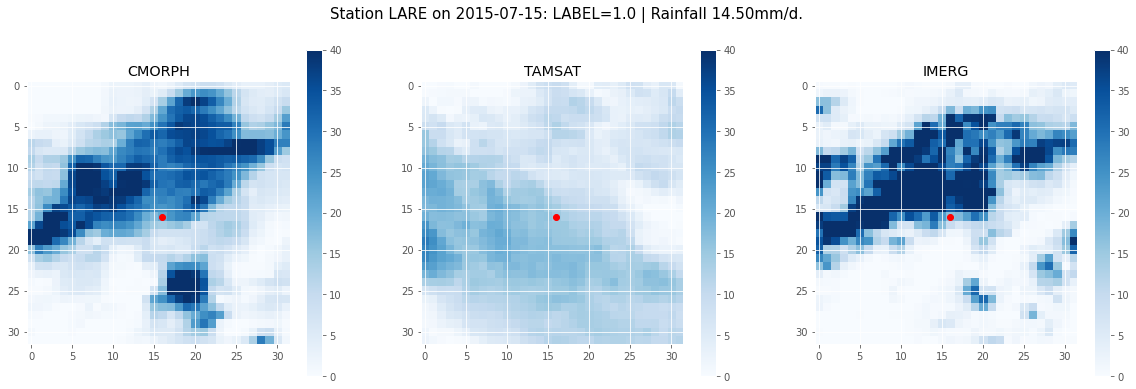

In [13]:
# select random image
ix = random.randint(0, x_tra.shape[0])
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ ind_tra[ ix ] ] ][0]


# set minimum and maximum in colorbars
prec_max = max( np.max(x[ix,:,:,0]) * m_CMORPH, np.max(x[ix,:,:,1]) * m_TAMSAT, np.max(x[ix,:,:,2]) * m_IMERG )
prec_max = min(prec_max, 40)  # set a threshold so it can be visible
# print(prec_max)


# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ind_tra[ix] ].date()}: LABEL={y_tra[ix]} | Rainfall {prec[ ind_tra[ ix ]]:.2f}mm/d.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = x_tra[ix, :, :, 0] * m_CMORPH
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH')  


plt.subplot(132)
img = x_tra[ix, :, :, 1] * m_TAMSAT
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT')  


plt.subplot(133)
img = x_tra[ix, :, :, 2] * m_IMERG
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.title(f'IMERG')


plt.colorbar();

### Similarity indices:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( x_tra[ix, :, :, 0].flatten(), x_tra[ix, :, :, 1].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( x_tra[ix, :, :, 0].flatten(), x_tra[ix, :, :, 2].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( x_tra[ix, :, :, 1].flatten(), x_tra[ix, :, :, 2].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  -0.12.
Correlation between CMORPH and IMERG:   0.24.
Correlation between TAMSAT and IMERG:   0.03.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = ((x_tra[ix, :, :, 0] // div) ).astype(int)
TAMSAT_classes = ((x_tra[ix, :, :, 1] // div) ).astype(int)
IMERG_classes  = ((x_tra[ix, :, :, 2] // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1 2 3]
TAMSAT has the following classes:  [ 0  1  2  3  4  5  7  9 15 20 21 23 24 25 30 35 37 46 48 49]
IMERG  has the following classes:  [0 1 2 3 4 5 6 7 8]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (50, 50, 1, 4) and homogeneity: 0.95.
TAMSAT has shape of: (50, 50, 1, 4) and homogeneity: 0.85.
IMERG  has shape of: (50, 50, 1, 4) and homogeneity: 0.93.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (10000,).
TAMSAT has length of: (10000,).
IMERG  has length of: (10000,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.41.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.15.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.40.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = x_tra[ix, :, :, 0].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = x_tra[ix, :, :, 1].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  = x_tra[ix, :, :, 2].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.42.
CMORPH and IMERG  have a Hamming distance of: 0.19.
TAMSAT and IMERG  have a Hamming distance of: 0.39.


## CMORPH PIs with Dropout Method

Define a function training and evaluating the predictions of the CMORPH model so that it can be used in a Monte Carlo simulation.

In [14]:
input_CMORPH = x_tra[:, :, :, 0]
input_TAMSAT = x_tra[:, :, :, 1]
input_IMERG  = x_tra[:, :, :, 2]
output_training = y_tra

input_st_CMORPH = x_tst[:, :, :, 0]
input_st_TAMSAT = x_tst[:, :, :, 1]
input_st_IMERG  = x_tst[:, :, :, 2]
output_testing = y_tst

print('Shapes of datasets')
print(input_TAMSAT.shape, output_training.shape, input_st_IMERG.shape, output_testing.shape)

Shapes of datasets
(11218, 32, 32) (11218,) (4808, 32, 32) (4808,)


In [15]:
# repeat to (32, 32, 3)

x_tra = np.zeros((len(x_tra), pixels, pixels, 3))
x_tst = np.zeros((len(x_tst), pixels, pixels, 3))

x_tra[:, :, :, 0] = input_CMORPH
x_tra[:, :, :, 1] = input_CMORPH
x_tra[:, :, :, 2] = input_CMORPH

x_tst[:, :, :, 0] = input_st_CMORPH
x_tst[:, :, :, 1] = input_st_CMORPH
x_tst[:, :, :, 2] = input_st_CMORPH

print(x_tra.shape)

(11218, 32, 32, 3)


In [16]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


In [17]:
x_tra[1111, 12, 12]

array([0.00079802, 0.00079802, 0.00079802])

In [25]:
def CMORPH_dropout(x_tra, x_tst, y_tra, y_tst):

  # MODEL ARCHITECTURE
  i = Input(shape=x_tra[0].shape, name='Input')

  x = Conv2D(8, (3, 3), strides=1, activation='relu', kernel_initializer='he_normal', padding='same', name='Convolutional_A1')(i)
  x = Conv2D(8, (3, 3), strides=1, activation='relu', kernel_initializer='he_normal', padding='same', name='Convolutional_A2')(x)
  x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

  x = Conv2D(16, (3, 3), strides=1, activation='relu', kernel_initializer='he_normal', padding='same', name='Convolutional_B1')(x)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', kernel_initializer='he_normal', padding='same', name='Convolutional_B2')(x)
  x = MaxPool2D(name='MaxPool2D_B')(x)

  x = Conv2D(32, (3, 3), strides=1, activation='relu', kernel_initializer='he_normal', padding='same', name='Convolutional_C1')(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', kernel_initializer='he_normal', padding='same', name='Convolutional_C2')(x)
  x = MaxPool2D(name='MaxPool2D_C')(x)

  x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

  x = Dropout(0.50, name='Dropout_1')(x)
  x = Dense(16, activation='tanh', kernel_initializer='he_normal', name='Hidden')(x)

  x = Dropout(0.50, name='Dropout_2')(x)
  x = Dense(1, activation='sigmoid', name='Output')(x)

  CMORPH_model = Model(i, x, name='CMORPH_model')

  # COMPILE AND RUN THE MODEL
  metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
            ]

  # compile the model
  CMORPH_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

  # fit the model and save the trajectories of loss and accuracy for training and test dataset
  r_CNN = CMORPH_model.fit(x_tra, y_tra, verbose = 0, epochs=30, batch_size=32)


  # DERIVE THE SIGMOID OUTPUT
  y_mod_CMORPH = CMORPH_model.predict(x_tst)

  # RETURN AN ARRAY WITH 1 PREDICTION FOR EACH FRAME
  return y_mod_CMORPH

# DEN EXO FTIAKSEI AKOMI DROPOUT METHOD

In [ ]:
N = 5  # Number of simulation
# y_mod_CMORPH = np.zeros((len(y_tst), N))  # 1 row for each frame, 1 collumn for each simulated value
# y_mod_CMORPH = []
print('THIS IS SIMULATION NUMBER', 1)
print(' ')
y_mod_CMORPH = CMORPH_dropout(x_tra, x_tst, y_tra, y_tst)

for i in range(N-1):  # number of simulations
  print('THIS IS SIMULATION NUMBER', i+2)
  print(' ')

  y_mod_CMORPH = np.column_stack((y_mod_CMORPH, CMORPH_dropout(x_tra, x_tst, y_tra, y_tst)))  # 1 row for each frame, 1 collumn for each simulated value

print(y_mod_CMORPH)

THIS IS SIMULATION NUMBER 1
 
THIS IS SIMULATION NUMBER 2
 
THIS IS SIMULATION NUMBER 3
 
THIS IS SIMULATION NUMBER 4
 


In [27]:
print(y_mod_CMORPH)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


# Loss functions for imbalanced binary classification

We are going to test some more possible loss functions for this problem: focal-loss and weighted binary crossentropy. We import and define these loss functions here.

### 1. Focal-loss

In [ ]:
!pip install tensorflow_addons  # tensorflow_addons is not in collab by default

     |████████████████████████████████| 706kB 5.6MB/s 


In [ ]:
# import focal loss function

import tensorflow_addons as tfa
FocalLoss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.2, gamma=2.0)  # (alpha=0.2, gamma=2.0) in paper


def focal_loss_custom(alpha, gamma):  # (alpha=0.2, gamma=2.0) in paper

   def binary_focal_loss(y_true, y_pred):

      FocalLoss = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      y_true_K = tf.ones_like(y_true)  # tf.ones_like instead of K.ones_like
      focal_loss = FocalLoss(y_true, y_pred)
      return focal_loss
      
   return binary_focal_loss

### 2. Weighted binary crossentropy

In [ ]:
"""
Created on Thu Feb 28 15:09:26 2019
@author: lhuang
"""


def dyn_weighted_bincrossentropy(true, pred):
    """
    Calculates weighted binary cross entropy. The weights are determined dynamically
    by the balance of each category. This weight is calculated for each batch.
    
    The weights are calculted by determining the number of 'pos' and 'neg' classes 
    in the true labels, then dividing by the number of total predictions.
    
    For example if there is 1 pos class, and 99 neg class, then the weights are 1/100 and 99/100.
    These weights can be applied so false negatives are weighted 99/100, while false postives are weighted
    1/100. This prevents the classifier from labeling everything negative and getting 99% accuracy.
    
    This can be useful for unbalanced catagories.
    """
    # get the total number of inputs
    num_pred = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) + keras.backend.sum(true)
    
    # get weight of values in 'pos' category
    zero_weight =  keras.backend.sum(true)/ num_pred +  keras.backend.epsilon() 
    
    # get weight of values in 'false' category
    one_weight = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) / num_pred +  keras.backend.epsilon()

    # calculate the weight vector
    weights =  (1.0 - true) * zero_weight +  true * one_weight 
    
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)


def weighted_bincrossentropy(true, pred, weight_zero = 0.7086116, weight_one = 1.69839933):  # custom weights updated by the sklearn results 
    """
    Calculates weighted binary cross entropy. The weights are fixed.
        
    This can be useful for unbalanced catagories.
    
    Adjust the weights here depending on what is required.
    
    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives 
        will be penalize 10 times as much as false negatives.
    """
  
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)

# Stacked-up 3 datasets

In [ ]:
# stacked_up_model = tf.keras.models.load_model(folder+'stacked_up_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 28.18%.
 
The percentage of rainy days in the TESTING dataset is 28.51%.


In [ ]:
# create model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A2')(x)
# x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B2')(x)
# x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.20, name='Dropout_1')(x)
x = Dense(16, activation='tanh', name='Hidden')(x)

x = Dropout(0.20, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

model = Model(i, x, name='Stacked_up_classifier')

# model summary
print('Model summary')
print("---" * 10)
print(model.summary())

Model summary
------------------------------
Model: "Classifier_CNN_from_scratch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 32, 32, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 16, 16, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 16, 16, 16)        1168      
_________________________________________________________________
Convolutional_B2 (Conv2D)    (None, 16, 16, 16)        2320      
____________________________________________________________

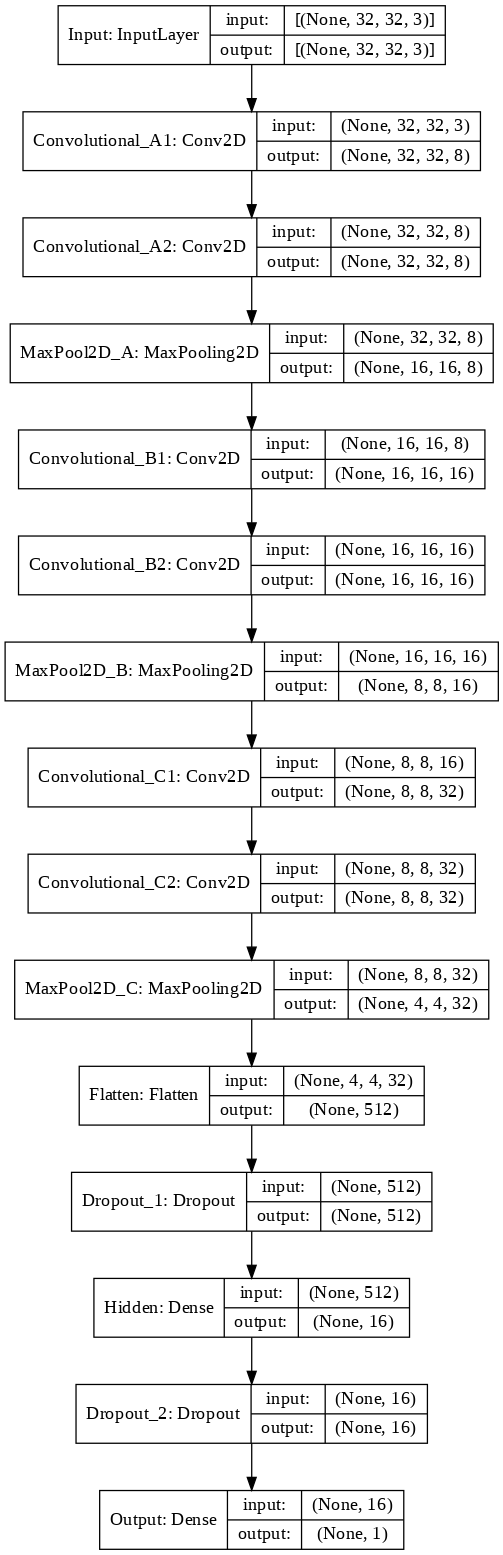

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.69620941 1.77414891]


In [ ]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = model.fit(x_tra, y_tra, verbose = 1, epochs=40, batch_size=64)

Epoch 1/40
201/201 [==============================] - 30s 139ms/step - loss: 0.6909 - accuracy: 0.6898 - precision_1: 0.3144 - recall_1: 0.0871
Epoch 2/40
201/201 [==============================] - 28s 139ms/step - loss: 0.6570 - accuracy: 0.7155 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 3/40
201/201 [==============================] - 28s 140ms/step - loss: 0.5690 - accuracy: 0.7159 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 4/40
201/201 [==============================] - 28s 141ms/step - loss: 0.5332 - accuracy: 0.7155 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 5/40
201/201 [==============================] - 28s 141ms/step - loss: 0.5091 - accuracy: 0.7130 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 6/40
201/201 [==============================] - 29s 143ms/step - loss: 0.5074 - accuracy: 0.7201 - precision_1: 0.3192 - recall_1: 0.0129
Epoch 7/40
201/201 [==============================] - 29s 142ms/step - loss: 0.5043 - accuracy: 0.7556 -

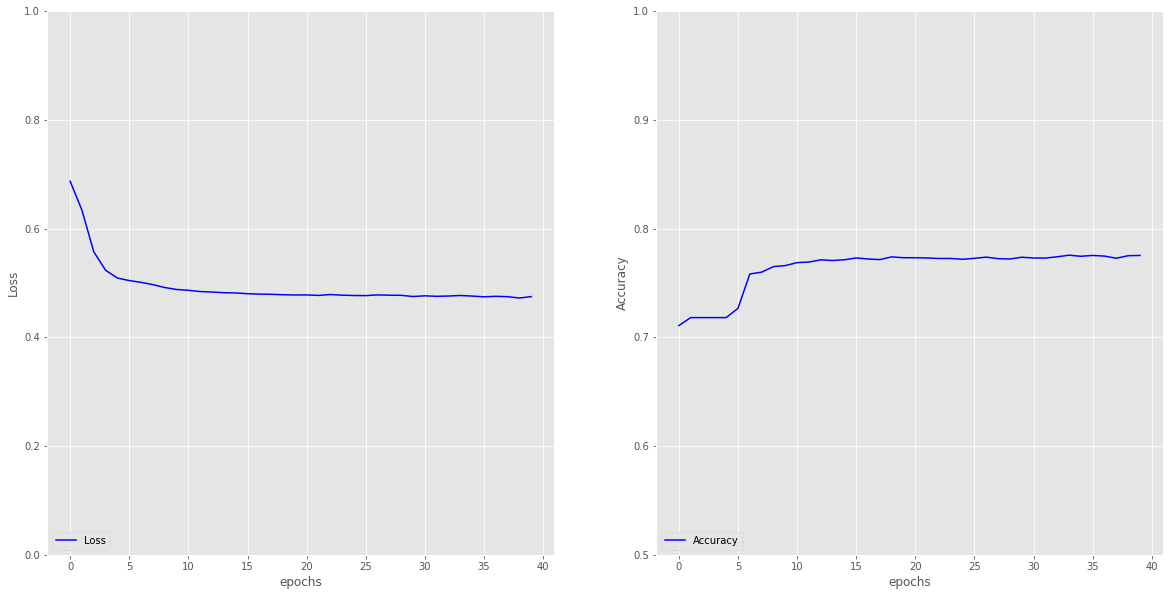

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod = model.predict(x_tst)>thr_mod
count = sum(y_mod)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
13/13 [==============================] - 2s 139ms/step - loss: 0.4673 - accuracy: 0.7735 - precision_1: 0.6386 - recall_1: 0.4737
 
Test loss: 0.46725907921791077
Test accuracy: 0.7735496163368225
Test AUC: 0.6386430859565735
 
Total rainy days:
--------------------
The model predicted 678 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.78      0.93      0.85      3461
        Rain       0.66      0.33      0.44      1347

    accuracy                           0.76      4808
   macro avg       0.72      0.63      0.64      4808
weighted avg       0.75      0.76      0.74      4808



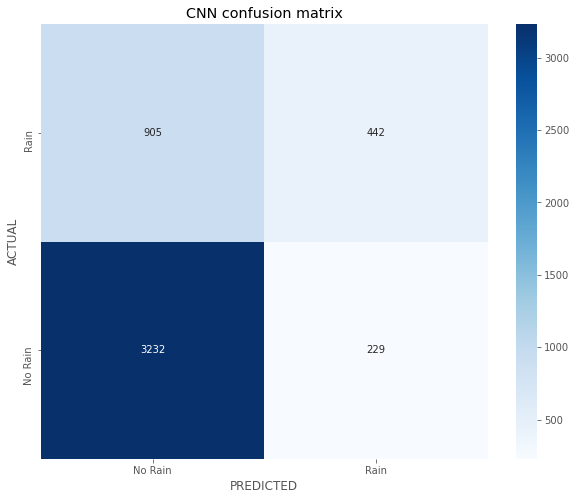

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

y_mod = stacked_up_model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod))
print('\n', classification_report(y_tst, y_mod, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('CNN confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod = stacked_up_model.predict(x_tst)
miss_index = [i for i, y in enumerate(y_tst) if y != (y_mod[i][0] > thr_mod)]

In [ ]:
# visual inspection

print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst))
print(' ')

for i in range(len(miss_index)):

  ix = miss_index[i]

  print(ix, y_tst[ix], y_mod[ix], y_mod[ix][0]>thr_mod)

Number of missclassified days: 1134 out of 4808
 
3 1.0 [0.37883568] False
5 1.0 [0.0782055] False
6 1.0 [0.25428635] False
7 1.0 [0.09276077] False
13 0.0 [0.559294] True
19 1.0 [0.09636492] False
21 1.0 [0.34180784] False
24 0.0 [0.55740935] True
27 1.0 [0.43589932] False
31 0.0 [0.5198042] True
35 1.0 [0.06957769] False
40 1.0 [0.25966787] False
60 0.0 [0.51523006] True
61 0.0 [0.53817457] True
63 1.0 [0.46076587] False
65 1.0 [0.20147267] False
69 1.0 [0.48058867] False
75 1.0 [0.49912837] False
77 1.0 [0.31344673] False
78 1.0 [0.12499273] False
82 1.0 [0.28843808] False
86 1.0 [0.37418473] False
87 1.0 [0.25327674] False
88 1.0 [0.17945173] False
92 1.0 [0.18553007] False
95 1.0 [0.4943899] False
105 1.0 [0.33425775] False
107 1.0 [0.24710456] False
108 1.0 [0.261903] False
110 0.0 [0.50963354] True
114 1.0 [0.3546865] False
116 0.0 [0.5341319] True
121 1.0 [0.31922495] False
122 1.0 [0.36606777] False
125 1.0 [0.43854254] False
127 1.0 [0.15366498] False
132 1.0 [0.36893916] Fal

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod[ miss_index ] >= 0.3) & (y_mod[ miss_index ] <= 0.7)) / len(miss_index) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod[ miss_index ] >= 0.3) & (y_mod[ miss_index ] <= 0.7)), 'out of', len(miss_index), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 678 out of 1134 i.e. 59.78835978835979 %.


### Missclassified images

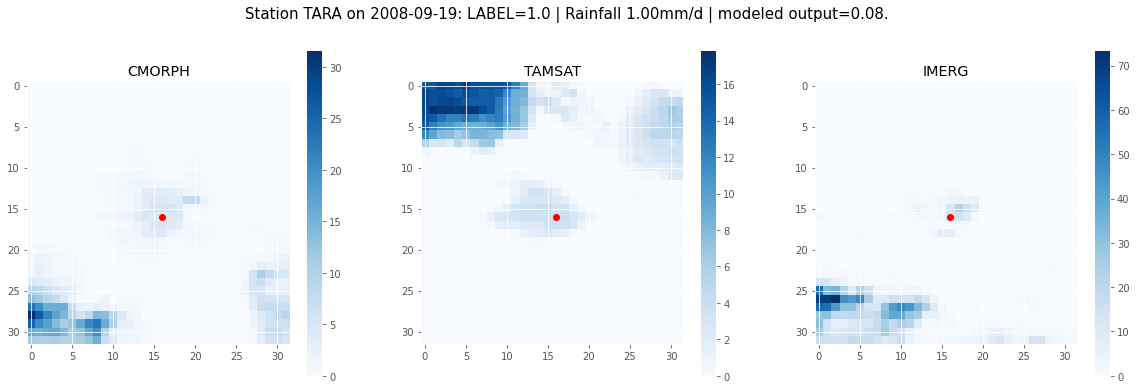

In [ ]:
# select random image
ix = miss_index[random.randint(0, len(miss_index))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]



# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | modeled output={y_mod[ix][0]:.2f}.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = x_tst[ix, :, :, 0] * m_CMORPH
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH')  


plt.subplot(132)
img = x_tst[ix, :, :, 1] * m_TAMSAT
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT')  


plt.subplot(133)
img = x_tst[ix, :, :, 2] * m_IMERG
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'IMERG');  

### Similarity indices of stacked-up model's misclassifications:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( x_tst[ix, :, :, 0].flatten(), x_tst[ix, :, :, 1].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( x_tst[ix, :, :, 0].flatten(), x_tst[ix, :, :, 2].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( x_tst[ix, :, :, 1].flatten(), x_tst[ix, :, :, 2].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  0.18.
Correlation between CMORPH and IMERG:   0.06.
Correlation between TAMSAT and IMERG:   0.32.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = ((x_tst[ix, :, :, 0] // div) ).astype(int)
TAMSAT_classes = ((x_tst[ix, :, :, 1] // div) ).astype(int)
IMERG_classes  = ((x_tst[ix, :, :, 2] // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1 2 3 4 5 6 7]
TAMSAT has the following classes:  [0 1]
IMERG  has the following classes:  [0]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (8, 8, 1, 4) and homogeneity: 0.96.
TAMSAT has shape of: (8, 8, 1, 4) and homogeneity: 0.98.
IMERG  has shape of: (8, 8, 1, 4) and homogeneity: 1.00.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (256,).
TAMSAT has length of: (256,).
IMERG  has length of: (256,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.17.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.24.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.14.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = x_tst[ix, :, :, 0].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = x_tst[ix, :, :, 1].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  = x_tst[ix, :, :, 2].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.22.
CMORPH and IMERG  have a Hamming distance of: 0.25.
TAMSAT and IMERG  have a Hamming distance of: 0.22.


Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p saved_model
model.save(folder+'stacked_up_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/stacked_up_model/assets


# Individual models

Save the training and test datasets

In [ ]:
input_CMORPH = x_tra[:, :, :, 0]
input_TAMSAT = x_tra[:, :, :, 1]
input_IMERG  = x_tra[:, :, :, 2]
output_training = y_tra

input_st_CMORPH = x_tst[:, :, :, 0]
input_st_TAMSAT = x_tst[:, :, :, 1]
input_st_IMERG  = x_tst[:, :, :, 2]
output_testing = y_tst

print('Shapes of datasets')
print(input_TAMSAT.shape, output_training.shape, input_st_IMERG.shape, output_testing.shape)

Shapes of datasets
(11218, 32, 32) (11218,) (4808, 32, 32) (4808,)


In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


## 1. CMORPH model

In [ ]:
# repeat to (32, 32, 3)

x_tra = np.zeros((len(x_tra), pixels, pixels, 3))
x_tst = np.zeros((len(x_tst), pixels, pixels, 3))

x_tra[:, :, :, 0] = input_CMORPH
x_tra[:, :, :, 1] = input_CMORPH
x_tra[:, :, :, 2] = input_CMORPH

x_tst[:, :, :, 0] = input_st_CMORPH
x_tst[:, :, :, 1] = input_st_CMORPH
x_tst[:, :, :, 2] = input_st_CMORPH

print(x_tra.shape)

(11218, 32, 32, 3)


In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


In [ ]:
x_tra[1111, 12, 12]

array([0.00079802, 0.00079802, 0.00079802])

In [ ]:
# CMORPH_model = tf.keras.models.load_model(folder+'UpdatedResolutions_CMORPH_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 25.81%.
 
The percentage of rainy days in the TESTING dataset is 26.63%.


In [23]:
# create CMORPH_model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), kernel_initializer='he_normal', strides=1, activation='relu', padding='same', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), kernel_initializer='he_normal', strides=1, activation='relu', padding='same', name='Convolutional_A2')(x)
# x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), kernel_initializer='he_normal', strides=1, activation='relu', padding='same', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), kernel_initializer='he_normal', strides=1, activation='relu', padding='same', name='Convolutional_B2')(x)
# x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

x = Conv2D(32, (3, 3), kernel_initializer='he_normal', strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
x = Conv2D(32, (3, 3), kernel_initializer='he_normal', strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.10, name='Dropout_1')(x)
x = Dense(16, kernel_initializer='he_normal', activation='tanh', name='Hidden')(x)

x = Dropout(0.10, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

CMORPH_model = Model(i, x, name='CMORPH_model')

# model summary
print('Model summary')
print("---" * 10)
print(CMORPH_model.summary())

Model summary
------------------------------
Model: "CMORPH_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 32, 32, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 16, 16, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 16, 16, 16)        1168      
_________________________________________________________________
Convolutional_B2 (Conv2D)    (None, 16, 16, 16)        2320      
_________________________________________________________________
MaxPool2D

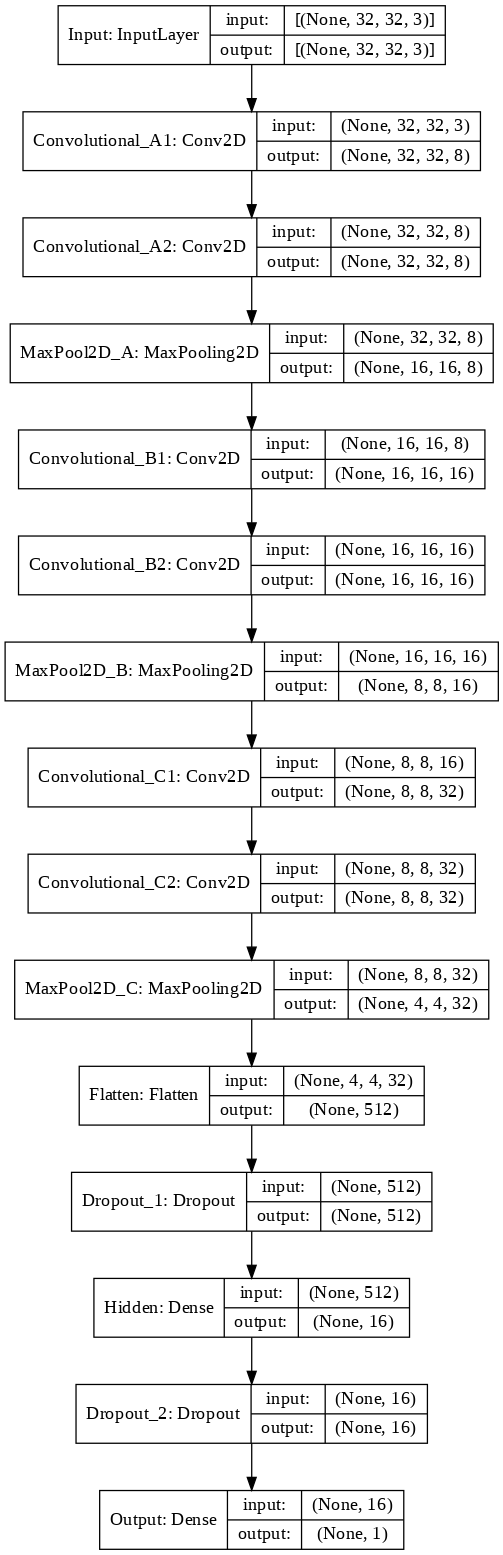

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(CMORPH_model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.67391304 1.9375    ]


In [22]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
CMORPH_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = CMORPH_model.fit(x_tra, y_tra, verbose = 1, epochs=20, batch_size=64)

Epoch 1/20
 27/176 [===>..........................] - ETA: 13s - loss: 0.6900 - accuracy: 0.7052 - precision_1: 0.1943 - recall_1: 0.0139

KeyboardInterrupt: ignored

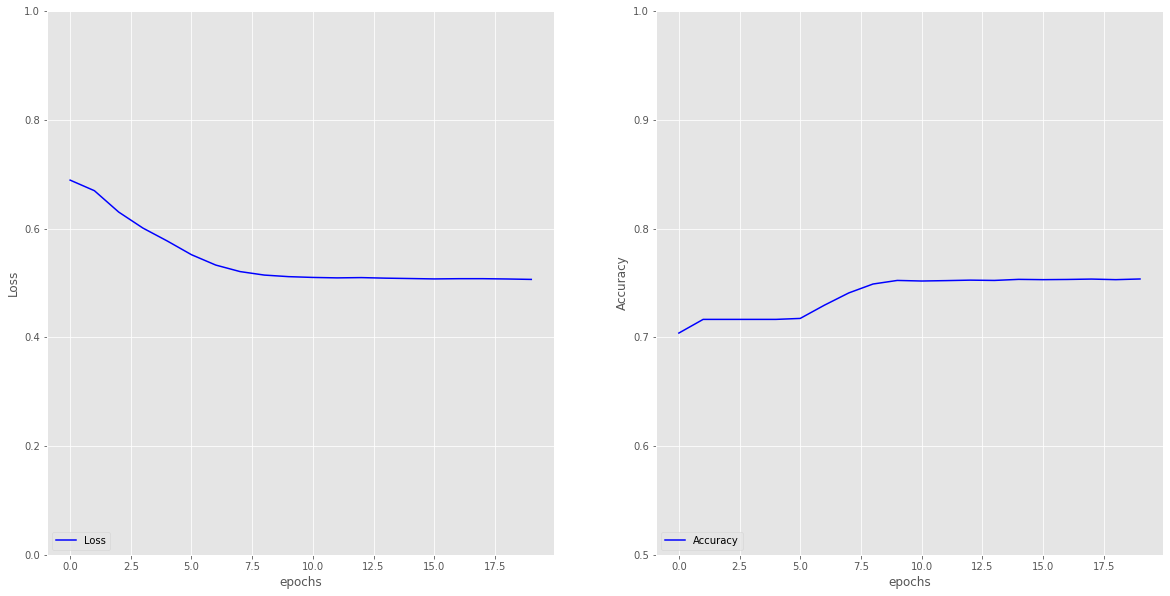

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the CMORPH_model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = CMORPH_model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod_CMORPH = CMORPH_model.predict(x_tst)>thr_mod
count = sum(y_mod_CMORPH)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
76/76 [==============================] - 3s 31ms/step - loss: 0.5000 - accuracy: 0.7552 - precision_5: 0.5982 - recall_5: 0.3846
 
Test loss: 0.49998506903648376
Test accuracy: 0.755199670791626
Test AUC: 0.5981523990631104
 
Total rainy days:
--------------------
The model predicted 866 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.79      0.90      0.84      3461
        Rain       0.60      0.38      0.47      1347

    accuracy                           0.76      4808
   macro avg       0.69      0.64      0.65      4808
weighted avg       0.74      0.76      0.74      4808



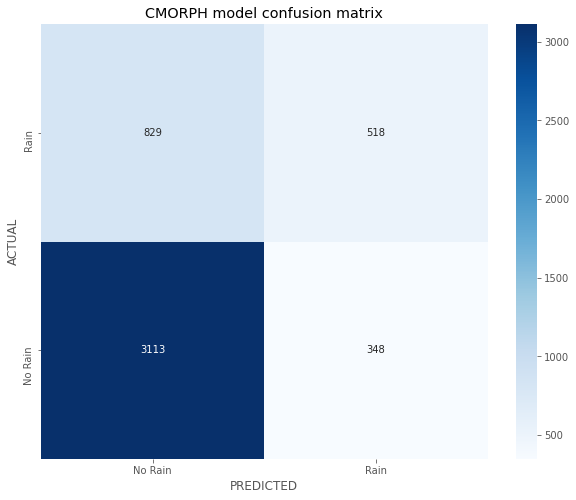

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

y_mod_CMORPH = CMORPH_model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod_CMORPH))
print('\n', classification_report(y_tst, y_mod_CMORPH, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('CMORPH model confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod_CMORPH = CMORPH_model.predict(x_tst)
miss_index_CMORPH = [i for i, y in enumerate(y_tst) if y != (y_mod_CMORPH[i][0] > thr_mod)]

In [ ]:
# visual inspection

# print('Number of missclassified days:', len(miss_index_CMORPH), 'out of', len(y_tst))
# print(' ')

# for i in range(len(miss_index_CMORPH)):

#   ix = miss_index_CMORPH[i]

#   print(ix, y_tst[ix], y_mod_CMORPH[ix], y_mod_CMORPH[ix][0]>thr_mod)

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod_CMORPH[ miss_index_CMORPH ] >= 0.3) & (y_mod_CMORPH[ miss_index_CMORPH ] <= 0.7)) / len(miss_index_CMORPH) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod_CMORPH[ miss_index_CMORPH ] >= 0.3) & (y_mod_CMORPH[ miss_index_CMORPH ] <= 0.7)), 'out of', len(miss_index_CMORPH), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 728 out of 1177 i.e. 61.85216652506372 %.


### Missclassified images

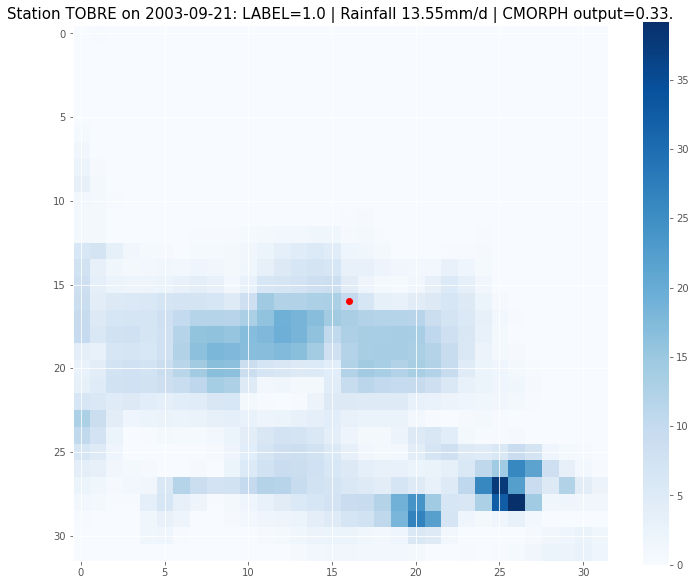

In [ ]:
# select random image
ix = miss_index_CMORPH[random.randint(0, len(miss_index_CMORPH))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]

# create subplots
plt.figure(figsize=(12, 10))
plt.title(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | CMORPH output={y_mod_CMORPH[ix][0]:.2f}.', fontsize=15)

img = x_tst[ix, :, :, 0] * m_CMORPH
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();

Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p UpdatedResolutions_saved_model
CMORPH_model.save(folder+'UpdatedResolutions_CMORPH_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/UpdatedResolutions_CMORPH_model/assets


## 2. TAMSAT model

In [ ]:
# repeat to (32, 32, 3)

x_tra = np.zeros((len(x_tra), pixels, pixels, 3))
x_tst = np.zeros((len(x_tst), pixels, pixels, 3))

x_tra[:, :, :, 0] = input_TAMSAT
x_tra[:, :, :, 1] = input_TAMSAT
x_tra[:, :, :, 2] = input_TAMSAT

x_tst[:, :, :, 0] = input_st_TAMSAT
x_tst[:, :, :, 1] = input_st_TAMSAT
x_tst[:, :, :, 2] = input_st_TAMSAT

print(x_tra.shape)

(11218, 32, 32, 3)


In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


In [ ]:
x_tra[1111, 12, 12, 0]

0.036916677499025094

In [ ]:
# TAMSAT_model = tf.keras.models.load_model(folder+'UpdatedResolutions_TAMSAT_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 28.35%.
 
The percentage of rainy days in the TESTING dataset is 28.02%.


In [ ]:
# create TAMSAT_model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A2')(x)
# x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B2')(x)
# x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.10, name='Dropout_1')(x)
x = Dense(16, activation='tanh', name='Hidden')(x)

x = Dropout(0.10, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

TAMSAT_model = Model(i, x, name='TAMSAT_model')

# model summary
print('Model summary')
print("---" * 10)
print(TAMSAT_model.summary())

Model summary
------------------------------
Model: "TAMSAT_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 32, 32, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 16, 16, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 16, 16, 16)        1168      
_________________________________________________________________
Convolutional_B2 (Conv2D)    (None, 16, 16, 16)        2320      
_________________________________________________________________
MaxPool2D

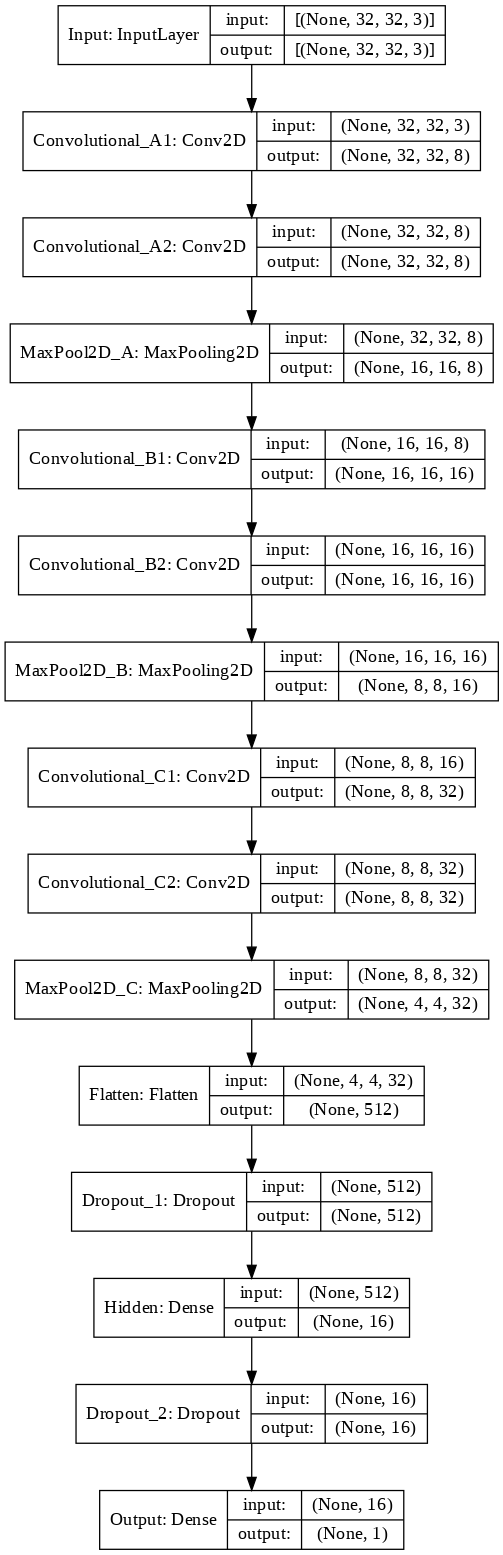

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(TAMSAT_model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.6978104  1.76383648]


In [ ]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
TAMSAT_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = TAMSAT_model.fit(x_tra, y_tra, verbose = 1, epochs=20, batch_size=64)

Epoch 1/20


KeyboardInterrupt: ignored

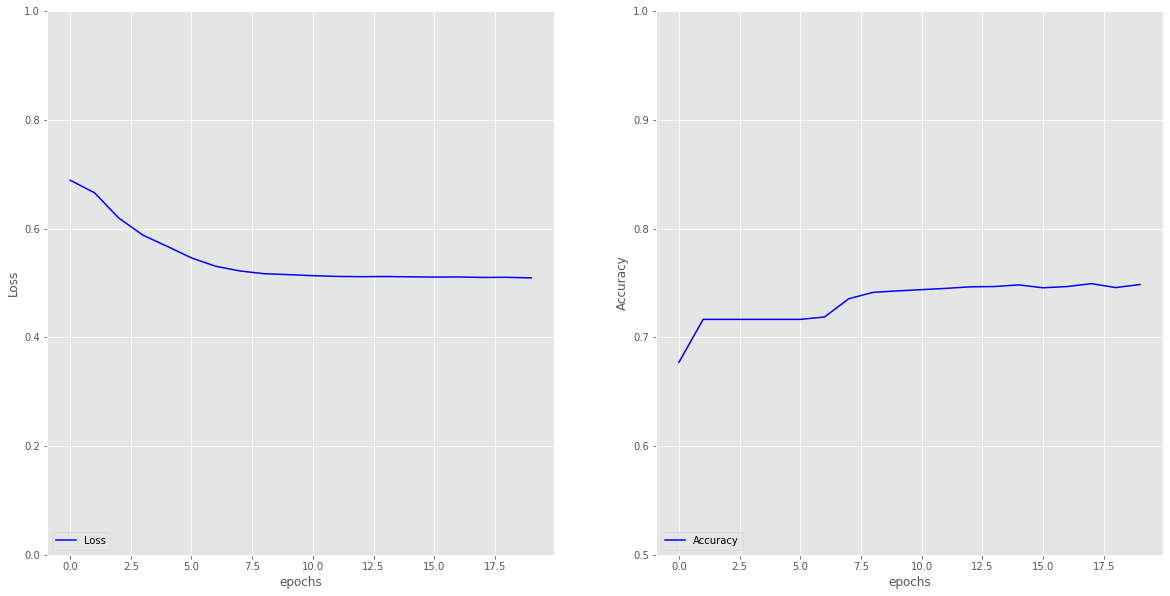

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the TAMSAT_model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = TAMSAT_model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod_TAMSAT = TAMSAT_model.predict(x_tst)>thr_mod
count = sum(y_mod_TAMSAT)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
76/76 [==============================] - 3s 30ms/step - loss: 0.4980 - accuracy: 0.7583 - precision: 0.6029 - recall: 0.4024
 
Test loss: 0.49802467226982117
Test accuracy: 0.7583194971084595
Test AUC: 0.6028921008110046
 
Total rainy days:
--------------------
The model predicted 899 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.79      0.90      0.84      3461
        Rain       0.61      0.40      0.48      1347

    accuracy                           0.76      4808
   macro avg       0.70      0.65      0.66      4808
weighted avg       0.74      0.76      0.74      4808



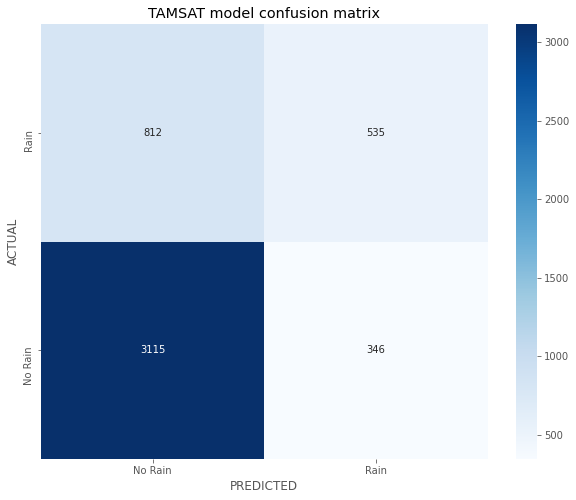

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

y_mod_TAMSAT = TAMSAT_model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod_TAMSAT))
print('\n', classification_report(y_tst, y_mod_TAMSAT, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('TAMSAT model confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod_TAMSAT = TAMSAT_model.predict(x_tst)
miss_index_TAMSAT = [i for i, y in enumerate(y_tst) if y != (y_mod_TAMSAT[i][0] > thr_mod)]

In [ ]:
# # visual inspection

# print('Number of missclassified days:', len(miss_index_TAMSAT), 'out of', len(y_tst))
# print(' ')

# for i in range(len(miss_index_TAMSAT)):

#   ix = miss_index_TAMSAT[i]

#   print(ix, y_tst[ix], y_mod_TAMSAT[ix], y_mod_TAMSAT[ix][0]>thr_mod)

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod_TAMSAT[ miss_index_TAMSAT ] >= 0.3) & (y_mod_TAMSAT[ miss_index_TAMSAT ] <= 0.7)) / len(miss_index_TAMSAT) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod_TAMSAT[ miss_index_TAMSAT ] >= 0.3) & (y_mod_TAMSAT[ miss_index_TAMSAT ] <= 0.7)), 'out of', len(miss_index_TAMSAT), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 737 out of 1162 i.e. 63.42512908777969 %.


### Missclassified images

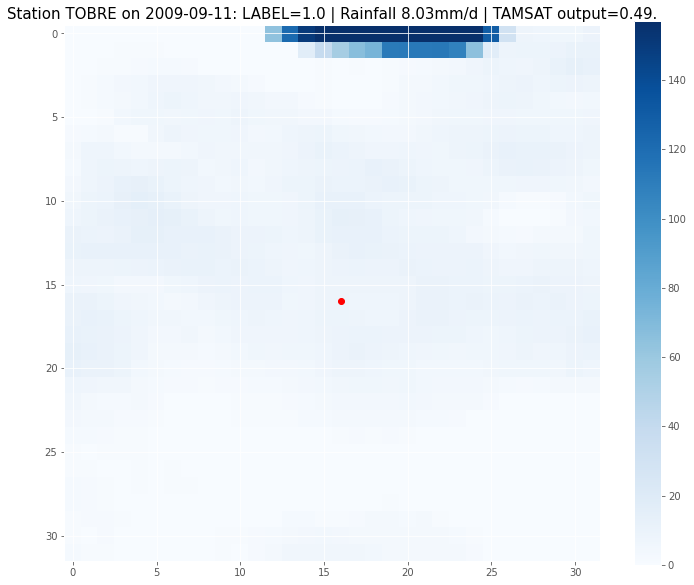

In [ ]:
# select random image
ix = miss_index_TAMSAT[random.randint(0, len(miss_index_TAMSAT))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]



# create subplots
plt.figure(figsize=(12, 10))
plt.title(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | TAMSAT output={y_mod_TAMSAT[ix][0]:.2f}.', fontsize=15)


img = x_tst[ix, :, :, 0] * m_TAMSAT

# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();

Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p UpdatedResolutions_saved_model
TAMSAT_model.save(folder+'UpdatedResolutions_TAMSAT_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/UpdatedResolutions_TAMSAT_model/assets


## 3. IMERG model

In [ ]:
# repeat to (32, 32, 3)

x_tra = np.zeros((len(x_tra), pixels, pixels, 3))
x_tst = np.zeros((len(x_tst), pixels, pixels, 3))

x_tra[:, :, :, 0] = input_IMERG
x_tra[:, :, :, 1] = input_IMERG
x_tra[:, :, :, 2] = input_IMERG

x_tst[:, :, :, 0] = input_st_IMERG
x_tst[:, :, :, 1] = input_st_IMERG
x_tst[:, :, :, 2] = input_st_IMERG

print(x_tra.shape)

(11218, 32, 32, 3)


In [ ]:
x_tra[1111, 12, 12, 0]

0.0

In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


In [ ]:
# IMERG_model = tf.keras.models.load_model(folder+'UpdatedResolutions_IMERG_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 28.35%.
 
The percentage of rainy days in the TESTING dataset is 28.02%.


In [ ]:
# create IMERG_model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='valid', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='valid', name='Convolutional_A2')(x)
# x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='valid', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='valid', name='Convolutional_B2')(x)
# x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
# x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.20, name='Dropout_1')(x)
x = Dense(16, activation='relu', name='Hidden')(x)

x = Dropout(0.20, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

IMERG_model = Model(i, x, name='IMERG_model')

# model summary
print('Model summary')
print("---" * 10)
print(IMERG_model.summary())

Model summary
------------------------------
Model: "IMERG_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 30, 30, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 28, 28, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 14, 14, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 12, 12, 16)        1168      
_________________________________________________________________
Convolutional_B2 (Conv2D)    (None, 10, 10, 16)        2320      
_________________________________________________________________
MaxPool2D_

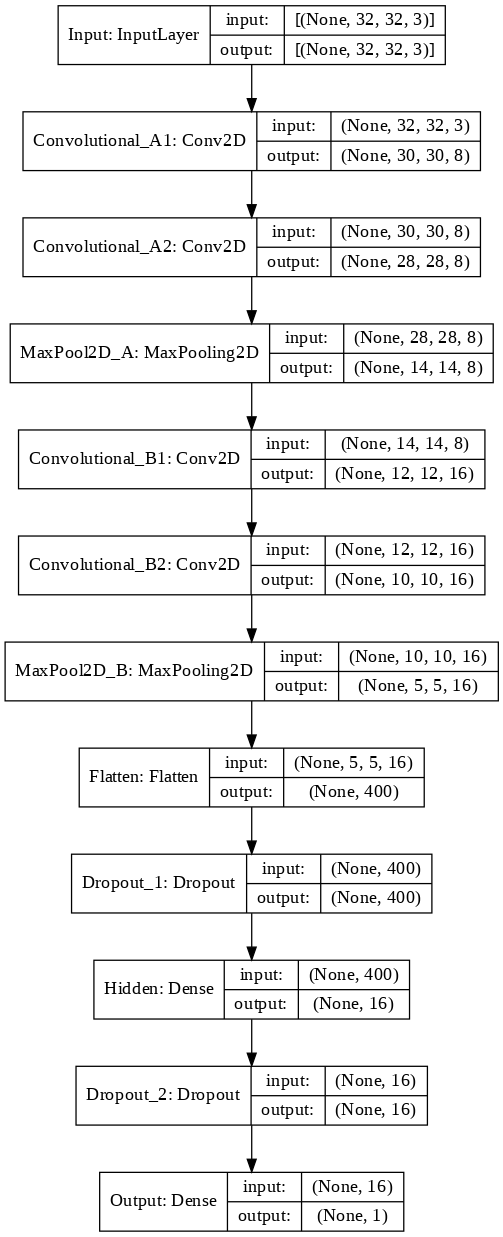

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(IMERG_model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.6978104  1.76383648]


In [ ]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
IMERG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = IMERG_model.fit(x_tra, y_tra, verbose = 1, epochs=30, batch_size=64)

Epoch 1/30
176/176 [==============================] - 26s 141ms/step - loss: 0.6901 - accuracy: 0.7053 - precision_7: 0.4117 - recall_7: 0.0860
Epoch 2/30
176/176 [==============================] - 25s 141ms/step - loss: 0.6520 - accuracy: 0.7222 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 3/30
176/176 [==============================] - 25s 141ms/step - loss: 0.5977 - accuracy: 0.7180 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 4/30
176/176 [==============================] - 25s 142ms/step - loss: 0.5884 - accuracy: 0.7182 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 5/30
176/176 [==============================] - 25s 141ms/step - loss: 0.5734 - accuracy: 0.7171 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 6/30
176/176 [==============================] - 25s 141ms/step - loss: 0.5520 - accuracy: 0.7122 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 7/30
176/176 [==============================] - 25s 141ms/step - loss: 0.5317 - accuracy: 

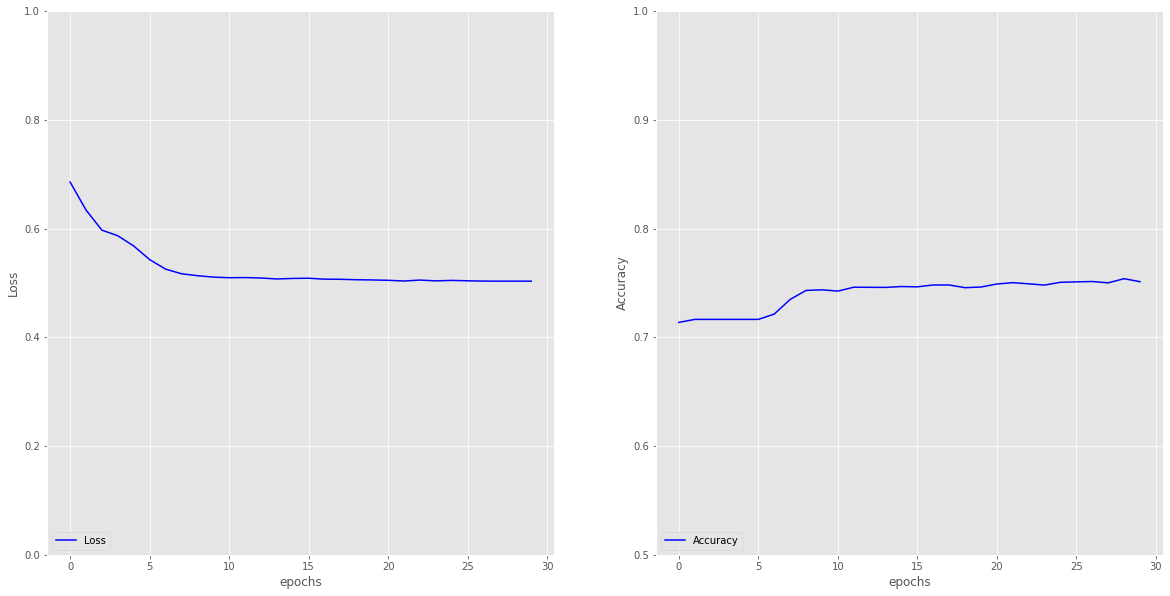

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the IMERG_model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = IMERG_model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod_IMERG = IMERG_model.predict(x_tst)>thr_mod
count = sum(y_mod_IMERG)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
76/76 [==============================] - 2s 20ms/step - loss: 0.4988 - accuracy: 0.7671 - precision_1: 0.6587 - recall_1: 0.3497
 
Test loss: 0.49876725673675537
Test accuracy: 0.7670549154281616
Test AUC: 0.6587412357330322
 
Total rainy days:
--------------------
The model predicted 715 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.82      0.87      0.85      3461
        Rain       0.61      0.52      0.56      1347

    accuracy                           0.77      4808
   macro avg       0.72      0.70      0.71      4808
weighted avg       0.77      0.77      0.77      4808



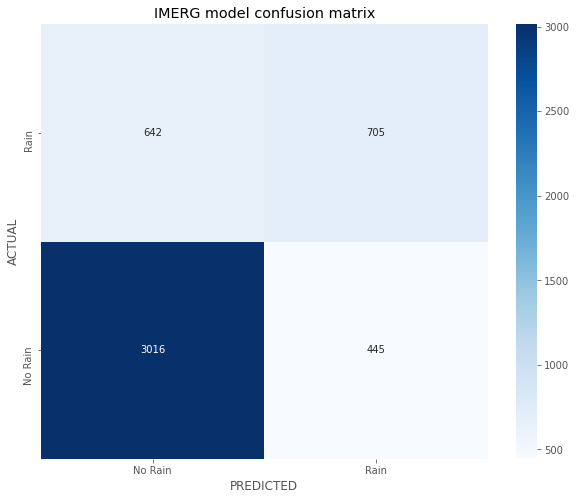

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

y_mod_IMERG = IMERG_model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod_IMERG))
print('\n', classification_report(y_tst, y_mod_IMERG, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('IMERG model confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod_IMERG = IMERG_model.predict(x_tst)
miss_index_IMERG = [i for i, y in enumerate(y_tst) if y != (y_mod_IMERG[i][0] > thr_mod)]

In [ ]:
# # visual inspection

# print('Number of missclassified days:', len(miss_index_IMERG), 'out of', len(y_tst))
# print(' ')

# for i in range(len(miss_index_IMERG)):

#   ix = miss_index_IMERG[i]

#   print(ix, y_tst[ix], y_mod_IMERG[ix], y_mod_IMERG[ix][0]>thr_mod)

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod_IMERG[ miss_index_IMERG ] >= 0.3) & (y_mod_IMERG[ miss_index_IMERG ] <= 0.7)) / len(miss_index_IMERG) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod_IMERG[ miss_index_IMERG ] >= 0.3) & (y_mod_IMERG[ miss_index_IMERG ] <= 0.7)), 'out of', len(miss_index_IMERG), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 525 out of 1120 i.e. 46.875 %.


### Missclassified images

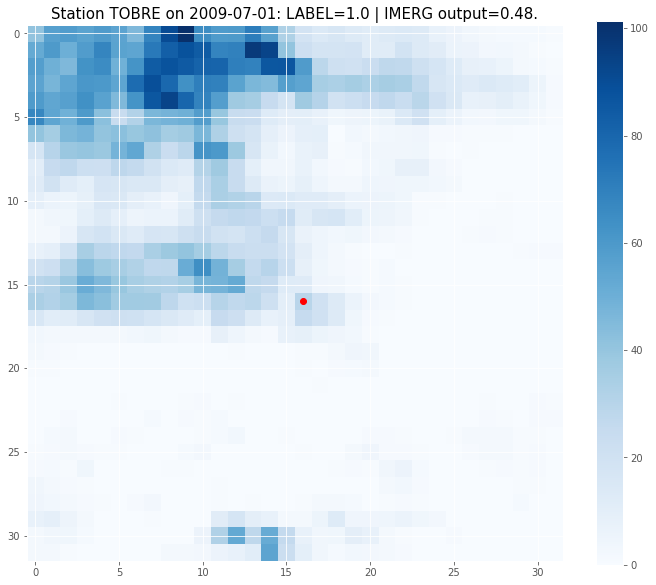

In [ ]:
# select random image
ix = miss_index_IMERG[random.randint(0, len(miss_index_IMERG))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]


# create subplots
plt.figure(figsize=(12, 10))
plt.title(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | IMERG output={y_mod_IMERG[ix][0]:.2f}.', fontsize=15)


img = x_tst[ix, :, :, 2] * m_IMERG

# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();

Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p UpdatedResolutions_saved_model
IMERG_model.save(folder+'UpdatedResolutions_IMERG_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/UpdatedResolutions_IMERG_model/assets


# Majority vote

### Assess individual datasets

In [ ]:
idx = np.intersect1d(miss_index_CMORPH, miss_index_TAMSAT, miss_index_IMERG)


per = len(idx) * 100 / min(len(miss_index_CMORPH), len(miss_index_TAMSAT), len(miss_index_IMERG))
print(f'Percentage of common misclasifications in (smallest) misclasification index: {per:.2f}%.')
print(' ')

per = len(idx) * 100 / len(y_tst)
# print(len(idx), idx)  # common index of 2
print(f'Percentage of common misclasifications out of total test dataset: {per:.2f}%.')
print(' ')
per = 100 - per
print(f'Can we assume that the maximum possible accuracy is {per:.2f}% ?')

Percentage of common misclasifications in (smallest) misclasification index: 89.02%.
 
Percentage of common misclasifications out of total test dataset: 20.74%.
 
Can we assume that the maximum possible accuracy is 79.26% ?


## Majority vote Alternative No.1

Assessing binary output

In [ ]:
y_mod = (y_mod_CMORPH>0.5).astype(int) + (y_mod_TAMSAT>0.5).astype(int) + (y_mod_IMERG>0.5).astype(int)

# get index of misclassified images
miss_index = [i for i, y in enumerate(y_tst) if y != (y_mod[i][0]>1.5)]

# visual inspection

print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst))
print(' ')

for i in range(len(miss_index)):

  ix = miss_index[i]

  print(ix, y_tst[ix], y_mod[ix], y_mod[ix][0]>1.5)

Number of missclassified days: 1150 out of 4808
 
3 1.0 [0] False
5 1.0 [0] False
6 1.0 [0] False
7 1.0 [0] False
19 1.0 [0] False
21 1.0 [1] False
24 0.0 [3] True
27 1.0 [0] False
31 0.0 [2] True
35 1.0 [0] False
40 1.0 [0] False
60 0.0 [2] True
61 0.0 [2] True
63 1.0 [1] False
65 1.0 [0] False
69 1.0 [1] False
75 1.0 [1] False
77 1.0 [0] False
78 1.0 [0] False
82 1.0 [0] False
86 1.0 [0] False
87 1.0 [0] False
88 1.0 [0] False
92 1.0 [0] False
105 1.0 [0] False
107 1.0 [0] False
108 1.0 [0] False
114 1.0 [0] False
121 1.0 [1] False
122 1.0 [1] False
125 1.0 [1] False
127 1.0 [0] False
132 1.0 [0] False
134 1.0 [0] False
136 0.0 [3] True
142 1.0 [0] False
146 1.0 [0] False
147 1.0 [0] False
155 1.0 [0] False
177 0.0 [2] True
186 1.0 [0] False
188 1.0 [0] False
189 0.0 [3] True
190 0.0 [2] True
191 1.0 [0] False
195 1.0 [1] False
198 0.0 [3] True
201 1.0 [1] False
207 1.0 [0] False
213 1.0 [0] False
215 1.0 [0] False
220 1.0 [0] False
222 1.0 [0] False
225 0.0 [3] True
226 1.0 [1] Fals

In [ ]:
per = np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)) / len(miss_index) * 100
print('The boarderline (between 0.9 and 2.1) missclassified days are', np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)), 'out of', len(miss_index), 'i.e.', per, '%.')

The boarderline (between 0.9 and 2.1) missclassified days are 359 out of 1150 i.e. 31.217391304347824 %.


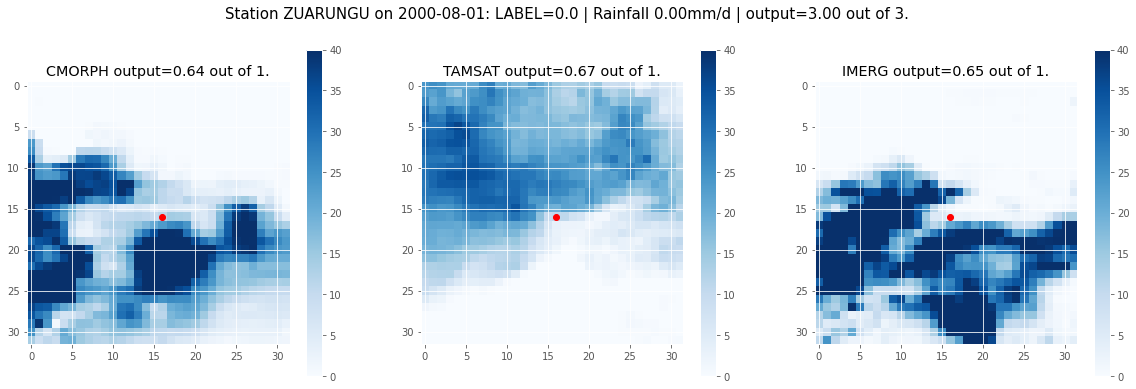

In [ ]:
# select random image
ix = miss_index[random.randint(0, len(miss_index))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]


# set minimum and maximum in colorbars
prec_max = max( np.max(input_st_CMORPH[ix,:,:]) * m_CMORPH, np.max(input_st_TAMSAT[ix,:,:]) * m_TAMSAT, np.max(input_st_IMERG[ix,:,:]) * m_IMERG )
prec_max = min(prec_max, 40)  # set a threshold so it can be visible



# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | output={y_mod[ix][0]:.2f} out of 3.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = input_st_CMORPH[ix, :, :] * m_CMORPH
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH output={y_mod_CMORPH[ix][0]:.2f} out of 1.')  


plt.subplot(132)
img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT output={y_mod_TAMSAT[ix][0]:.2f} out of 1.')   


plt.subplot(133)
img = input_st_IMERG[ix, :, :] * m_IMERG
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'IMERG output={y_mod_IMERG[ix][0]:.2f} out of 1.');

### Similarity indices of Majority No.1 model's misclassifications:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_TAMSAT[ix, :, :].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( input_st_TAMSAT[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  -0.28.
Correlation between CMORPH and IMERG:   0.14.
Correlation between TAMSAT and IMERG:   -0.29.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = (( input_st_CMORPH[ix, :, :] // div) ).astype(int)
TAMSAT_classes = (( input_st_TAMSAT[ix, :, :] // div) ).astype(int)
IMERG_classes  = (( input_st_IMERG[ix, :, :]  // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1 2 3 4 5]
TAMSAT has the following classes:  [0 1 2 3 4 5 6]
IMERG  has the following classes:  [0 1 2 3 4 5 6]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (7, 7, 1, 4) and homogeneity: 0.96.
TAMSAT has shape of: (7, 7, 1, 4) and homogeneity: 0.90.
IMERG  has shape of: (7, 7, 1, 4) and homogeneity: 0.95.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (196,).
TAMSAT has length of: (196,).
IMERG  has length of: (196,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.32.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.09.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.34.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = input_st_CMORPH[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = input_st_TAMSAT[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  =  input_st_IMERG[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.62.
CMORPH and IMERG  have a Hamming distance of: 0.20.
TAMSAT and IMERG  have a Hamming distance of: 0.70.


### Confusion matrix

In [ ]:
y_mod = y_mod>1.5  # threshold between 0 and 3

per = sum(y_mod) * 100 / len(y_mod)
print(f'Percentage of modeled wet day: {per[0]:.2f}%.')

Percentage of modeled wet day: 16.91%.



               precision    recall  f1-score   support

     No Rain       0.79      0.91      0.85      3461
        Rain       0.62      0.37      0.47      1347

    accuracy                           0.76      4808
   macro avg       0.71      0.64      0.66      4808
weighted avg       0.74      0.76      0.74      4808



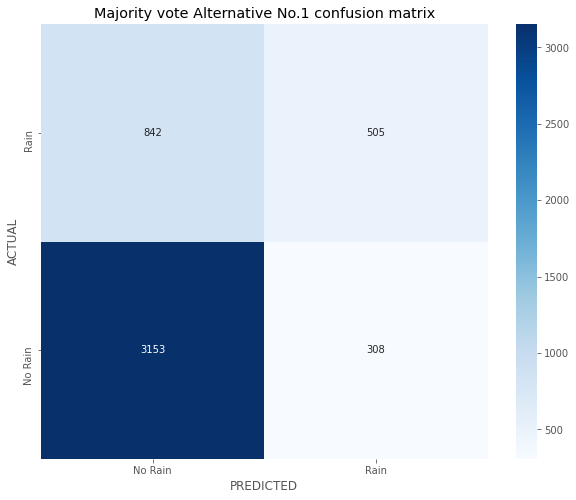

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

conf_matrix.append(confusion_matrix(y_tst, y_mod))
print('\n', classification_report(y_tst, y_mod, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('Majority vote Alternative No.1 confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

## Majority vote Alternative No.2

Assessing raw output

In [ ]:
y_mod = y_mod_CMORPH + y_mod_TAMSAT + y_mod_IMERG

# get index of misclassified images
miss_index = [i for i, y in enumerate(y_tst) if y != (y_mod[i][0]>1.5)]

# visual inspection

print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst))
print(' ')

for i in range(len(miss_index)):

  ix = miss_index[i]

  print(ix, y_tst[ix], y_mod[ix], y_mod[ix][0]>1.5)

Number of missclassified days: 1136 out of 4808
 
3 1.0 [1.3788707] False
5 1.0 [0.3565796] False
6 1.0 [0.6541473] False
7 1.0 [0.43741393] False
13 0.0 [1.6447923] True
19 1.0 [0.4543087] False
21 1.0 [1.2582055] False
24 0.0 [1.8956048] True
27 1.0 [1.1746521] False
31 0.0 [1.6826134] True
35 1.0 [0.38299793] False
40 1.0 [0.7208398] False
60 0.0 [1.6631899] True
61 0.0 [1.5617778] True
63 1.0 [1.4559486] False
65 1.0 [0.67885685] False
69 1.0 [1.3355443] False
75 1.0 [1.440104] False
77 1.0 [1.254553] False
78 1.0 [0.4069629] False
82 1.0 [0.8901495] False
86 1.0 [1.217447] False
87 1.0 [0.8016701] False
88 1.0 [0.58458865] False
92 1.0 [0.6977638] False
105 1.0 [0.821126] False
107 1.0 [0.74264604] False
108 1.0 [1.0981786] False
114 1.0 [1.2072471] False
121 1.0 [0.92504525] False
122 1.0 [1.2756855] False
125 1.0 [1.2443728] False
127 1.0 [0.64189625] False
132 1.0 [1.3818612] False
134 1.0 [0.858629] False
136 0.0 [1.9799194] True
142 1.0 [0.39014816] False
146 1.0 [0.868507] F

In [ ]:
per = np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)) / len(miss_index) * 100
print('The boarderline (between 0.9 and 2.1) missclassified days are', np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)), 'out of', len(miss_index), 'i.e.', per, '%.')

The boarderline (between 0.9 and 2.1) missclassified days are 681 out of 1136 i.e. 59.94718309859155 %.


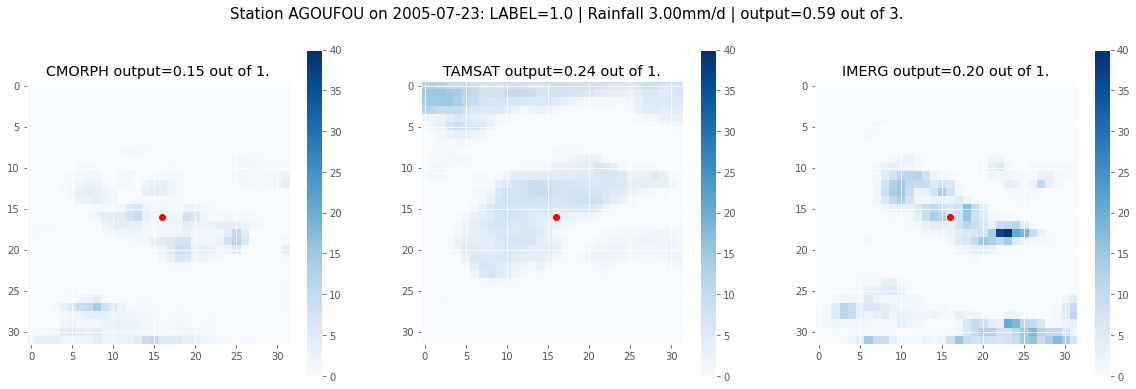

In [ ]:
# select random image
ix = miss_index[random.randint(0, len(miss_index))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]

# set minimum and maximum in colorbars
prec_max = max( np.max(input_st_CMORPH[ix,:,:]) * m_CMORPH, np.max(input_st_TAMSAT[ix,:,:]) * m_TAMSAT, np.max(input_st_IMERG[ix,:,:]) * m_IMERG )
prec_max = min(prec_max, 40)  # set a threshold so it can be visible



# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | output={y_mod[ix][0]:.2f} out of 3.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = input_st_CMORPH[ix, :, :] * m_CMORPH
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH output={y_mod_CMORPH[ix][0]:.2f} out of 1.')  


plt.subplot(132)
img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT output={y_mod_TAMSAT[ix][0]:.2f} out of 1.')   


plt.subplot(133)
img = input_st_IMERG[ix, :, :] * m_IMERG
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'IMERG output={y_mod_IMERG[ix][0]:.2f} out of 1.');  

### Similarity indices of Majority No.2 model's misclassifications:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_TAMSAT[ix, :, :].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( input_st_TAMSAT[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  -0.01.
Correlation between CMORPH and IMERG:   0.01.
Correlation between TAMSAT and IMERG:   -0.02.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = (( input_st_CMORPH[ix, :, :] // div) ).astype(int)
TAMSAT_classes = (( input_st_TAMSAT[ix, :, :] // div) ).astype(int)
IMERG_classes  = (( input_st_IMERG[ix, :, :]  // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1]
TAMSAT has the following classes:  [ 0  1  2  3  4  5  6 12 17 19 20 21 23 33 35 38 41 47 49]
IMERG  has the following classes:  [0 1 2 3 4 6 7]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (50, 50, 1, 4) and homogeneity: 1.00.
TAMSAT has shape of: (50, 50, 1, 4) and homogeneity: 0.95.
IMERG  has shape of: (50, 50, 1, 4) and homogeneity: 0.98.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (10000,).
TAMSAT has length of: (10000,).
IMERG  has length of: (10000,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.23.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.10.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.19.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = input_st_CMORPH[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = input_st_TAMSAT[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  =  input_st_IMERG[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.20.
CMORPH and IMERG  have a Hamming distance of: 0.28.
TAMSAT and IMERG  have a Hamming distance of: 0.23.


### Confusion matrix

In [ ]:
y_mod = y_mod>1.5  # threshold between 0 and 3

per = sum(y_mod) * 100 / len(y_mod)
print(f'Percentage of modeled wet day: {per[0]:.2f}%.')

Percentage of modeled wet day: 15.37%.



               precision    recall  f1-score   support

     No Rain       0.79      0.92      0.85      3461
        Rain       0.64      0.35      0.46      1347

    accuracy                           0.76      4808
   macro avg       0.71      0.64      0.65      4808
weighted avg       0.75      0.76      0.74      4808



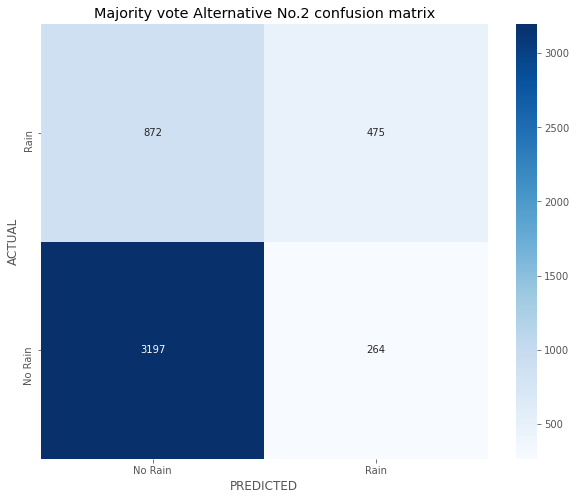

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

conf_matrix.append(confusion_matrix(y_tst, y_mod))
print('\n', classification_report(y_tst, y_mod, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('Majority vote Alternative No.2 confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

### Dry day misclassifications HISTOGRAM

In [ ]:
print('Number of misclassified days:', len(miss_index))

miss_wet = [i for i in (miss_index) if (y_tst[i] == 1.0)]  # misclassified wet days
print('Number of wet days misclassified as dry days:', len(miss_wet))

Number of misclassified days: 1136
Number of wet days misclassified as dry days: 872


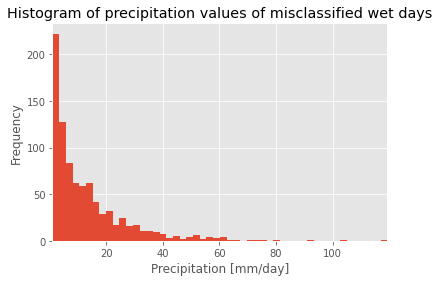

In [ ]:
prec_miss_wet = prec[ ind_tst[miss_wet] ]

plt.title('Histogram of precipitation values of misclassified wet days')
plt.hist(prec_miss_wet, bins=50, range=(1.0, prec_miss_wet.max()))
plt.xlabel('Precipitation [mm/day]')
plt.ylabel('Frequency')
plt.xlim([1.0, prec_miss_wet.max()]);

### Save the miss_index

In [ ]:
# save the miss_index

from google.colab import files
np.savetxt('MissIndexMajorityModel2.txt', miss_index)


# download the total dataframe

# files.download('MissIndexMajorityModel2.txt')


# save in google drive

!cp MissIndexMajorityModel2.txt "./gdrive/My Drive/Deep-Learning/"

### Interpret the misclassified index

In [ ]:
print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst), 'in the test dataset')

Number of missclassified days: 1136 out of 4808 in the test dataset


In [ ]:
time_error_daily = np.sum(np.diff(miss_index, n=1) == 1)
print(f'{time_error_daily:.0f} times misclassifications happen in two consecutive days.')
print(f'Can we assume that {2 * time_error_daily:.0f} misclassifications out of all happen because of timing error in the daily scale?')

250 times misclassifications happen in two consecutive days.
Can we assume that 500 misclassifications out of all happen because of timing error in the daily scale?
